# Segmentación de Conjuntiva Palpebral con Transformers (SegFormer)

Este notebook documenta el proceso de entrenamiento y validación de un modelo de segmentación basado en la arquitectura SegFormer (modelo preentrenado `nvidia/segformer-b0-finetuned-ade-512-512`), adaptado para identificar la región de la conjuntiva palpebral en imágenes oculares.  

### Contexto del proyecto
Inicialmente se empleó una arquitectura U-Net para segmentar imágenes de conjuntiva palpebral provenientes de una base de datos con pacientes de India e Italia; sin embargo, se obtuvieron resultados inconsistentes al probar con imágenes externas. Por esta razón, se optó por utilizar un modelo basado en Transformers (SegFormer) preentrenado, adaptándolo a nuestro dataset personalizado con máscaras binarizadas.

Posteriormente, incorporamos imágenes propias (15 fotografías capturadas y segmentadas manualmente mediante MakeSense.ai) para realizar un ajuste fino (fine-tuning), lo cual mejoró significativamente la capacidad del modelo para generalizar y mantener una segmentación estable en imágenes no vistas.

Además, realizamos un proceso de data augmentation mediante geometric transformations for generalization. Estas transformaciones permiten que el modelo sea más robusto ante diferentes condiciones de captura, simulando variaciones reales en ángulo, iluminación y posición del ojo, lo que incrementa su desempeño en entornos clínicos y no controlados.

El modelo resultante constituye el primer paso de un sistema completo de diagnóstico no invasivo de anemia, en el cual la salida de esta segmentación servirá como entrada para un segundo modelo encargado de estimar los niveles de hemoglobina en la conjuntiva palpebral.

## 1. Instalación de dependencias
Se instalan las librerías necesarias para cargar y entrenar el modelo (Transformers de HuggingFace y datasets).

In [ ]:
!pip install transformers datasets


## 2. Carga del modelo base y procesador modificado

Se carga el modelo preentrenado `nvidia/segformer-b0-finetuned-ade-512-512` y su respectivo procesador desde HuggingFace. Este modelo fue originalmente entrenado con el dataset ADE20K, que incluye **150 clases de segmentación semántica** (como árboles, edificios, cielo, ropa, partes del cuerpo, etc.).

Sin embargo, para nuestro caso de uso —segmentar únicamente la región de la **conjuntiva palpebral**— no se requieren múltiples clases. Por ello, **se modifica la arquitectura del modelo** para trabajar con **solo 2 clases**:
- **Clase 0:** Fondo (todo lo que no es conjuntiva)
- **Clase 1:** Región de la conjuntiva palpebral

Esto permite un enfoque binario que facilita la tarea y mejora la precisión del modelo al enfocarse exclusivamente en la zona de interés.

In [ ]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# Cargar el procesador y el modelo preentrenado
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
#model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,
    ignore_mismatched_sizes=True
)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:410: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Confirmación del número de clases

Se imprime el número total de clases que el modelo espera segmentar tras la modificación: **2 clases** (fondo y conjuntiva).


In [ ]:
print("Clases esperadas por el modelo:", model.config.num_labels)


Clases esperadas por el modelo: 2


## 3. Ligar con Google Drive

Se conecta Google Drive al entorno de Colab para acceder al dataset personalizado almacenado en la nube.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 4. Definición de rutas

Se definen las rutas locales (en Google Drive) donde están almacenadas las imágenes y las máscaras binarizadas

In [ ]:
# Definir rutas correctas
image_dir = "/content/drive/MyDrive/segmentation_dataset/images"
mask_dir  = "/content/drive/MyDrive/segmentation_dataset/binarized_masks"

### Verificación de archivos cargados

Se listan algunos nombres de archivos para confirmar que las rutas especificadas contienen imágenes y máscaras válidas.

In [ ]:
import os

print("Ejemplos de imágenes:", os.listdir(image_dir)[:5])
print("Ejemplos de máscaras:", os.listdir(mask_dir)[:5])


Ejemplos de imágenes: ['India001.jpg', 'India007.jpg', 'India006.jpg', 'India002.jpg', 'India005.jpg']
Ejemplos de máscaras: ['India003.png', 'India007.png', 'India009.png', 'India008.png', 'India002.png']


## 5. Eliminación de máscaras con área blanca mínima

Durante la revisión del dataset, se detectaron varias máscaras binarias que contenían solo un pequeño punto blanco o estaban casi completamente negras. Este tipo de ejemplos puede confundir al modelo durante el entrenamiento, ya que no aportan una señal clara sobre la región de interés.

Por esta razón, se implementó un filtro que elimina aquellas máscaras cuya proporción de píxeles blancos (i.e., la región segmentada) es menor al **1% del total de la imagen**. Además, se eliminan también las imágenes correspondientes, ya que sin su máscara no pueden usarse para entrenamiento.

En la siguiente imagen se muestra un ejemplo de las máscaras que motivaron esta limpieza, donde se aprecia que varias contienen apenas unos cuantos píxeles blancos:

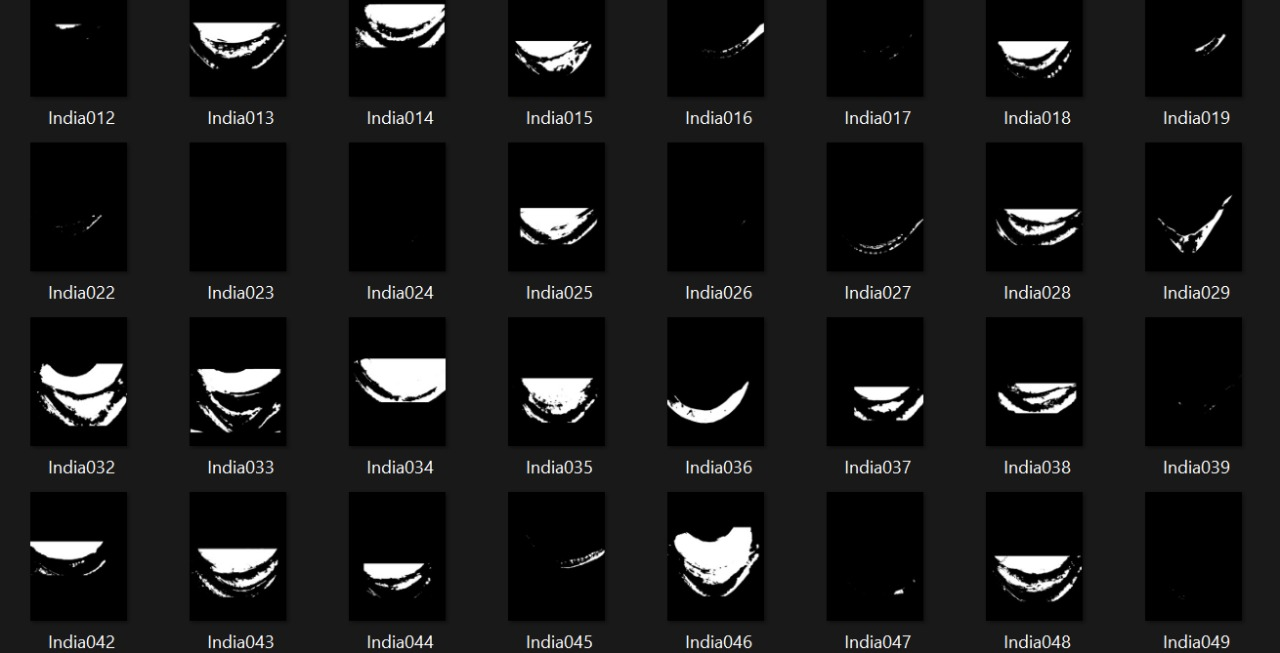

> Nota: aunque el resultado visible en la ejecución muestra “0 eliminadas”, esto se debe a que la celda se ejecutó después de haber hecho una primera limpieza. En realidad, se eliminaron **33 imágenes** en esa primera pasada.

In [ ]:
from PIL import Image
import numpy as np
import os

deleted = 0
threshold_ratio = 0.01  # 1% de área blanca mínima

for filename in os.listdir(mask_dir):
    if not (filename.endswith(".png") or filename.endswith(".jpg")):
        continue

    mask_path = os.path.join(mask_dir, filename)
    mask = Image.open(mask_path).convert("L")
    mask_np = np.array(mask)

    total_pixels = mask_np.size
    white_pixels = np.sum(mask_np > 0)
    white_ratio = white_pixels / total_pixels

    if white_ratio < threshold_ratio:
        # Eliminar la máscara
        os.remove(mask_path)

        # Eliminar la imagen correspondiente (mismo nombre)
        image_path = os.path.join(image_dir, filename)
        if os.path.exists(image_path):
            os.remove(image_path)

        deleted += 1

print(f"Se eliminaron {deleted} imágenes con área blanca < {threshold_ratio*100:.1f}%")

Se eliminaron 0 imágenes con área blanca < 1.0%


## 6. Eliminación de imágenes sin máscara correspondiente

En este paso se realiza una limpieza adicional para asegurar que cada imagen en la carpeta `images/` tenga su correspondiente máscara en la carpeta `binarized_masks/`.

Esto es esencial, ya que el modelo requiere pares válidos (imagen y máscara) para poder entrenar. Cualquier imagen sin máscara es descartada para evitar errores durante la preparación del dataset.


In [ ]:
import os

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")])
mask_files  = sorted([f for f in os.listdir(mask_dir) if f.endswith(".jpg") or f.endswith(".png")])

# Convertimos a sets para comparación
image_names = set(os.path.splitext(f)[0] for f in image_files)
mask_names  = set(os.path.splitext(f)[0] for f in mask_files)

# Identificar imágenes que no tienen máscara
images_without_mask = image_names - mask_names

print(f"Se encontraron {len(images_without_mask)} imágenes sin máscara. Serán eliminadas...")

deleted = 0
for name in images_without_mask:
    for ext in [".jpg", ".png"]:
        image_path = os.path.join(image_dir, name + ext)
        if os.path.exists(image_path):
            os.remove(image_path)
            deleted += 1

print(f"Eliminadas {deleted} imágenes sin máscara.")


Se encontraron 0 imágenes sin máscara. Serán eliminadas...
Eliminadas 0 imágenes sin máscara.


### Verificación de la cantidad final de pares válidos

En esta parte verificamos que la cantidad de imágenes y sus respectivas máscaras binarizadas coincidan después del proceso de limpieza realizado anteriormente.  
Este paso es fundamental para asegurarnos de que cada imagen tenga su correspondiente máscara segmentada, evitando así errores al momento de cargar los datos en el modelo.

Aquí confirmamos que ambos conjuntos contienen la misma cantidad de archivos válidos, lo cual nos garantiza que todos los pares imagen/máscara están correctamente emparejados y listos para ser utilizados durante el entrenamiento.

In [ ]:
import os
import pandas as pd

# Solo tomar archivos que todavía existen
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")])
mask_files  = sorted([f for f in os.listdir(mask_dir) if f.endswith(".jpg") or f.endswith(".png")])

# Confirmar que hay misma cantidad
print(f"{len(image_files)} imágenes y {len(mask_files)} máscaras")

# Crear DataFrame
df = pd.DataFrame({
    "image_path": [os.path.join(image_dir, f) for f in image_files],
    "mask_path": [os.path.join(mask_dir, f) for f in mask_files]
})

# Visualizar
df.sample(3)

133 imágenes y 133 máscaras


image_path  \
86  /content/drive/MyDrive/segmentation_dataset/im...   
15  /content/drive/MyDrive/segmentation_dataset/im...   
6   /content/drive/MyDrive/segmentation_dataset/im...   

                                            mask_path  
86  /content/drive/MyDrive/segmentation_dataset/bi...  
15  /content/drive/MyDrive/segmentation_dataset/bi...  
6   /content/drive/MyDrive/segmentation_dataset/bi...

## 7. Preprocesamiento de datos e integración al formato HuggingFace

En esta sección realizamos el preprocesamiento de nuestros datos para prepararlos de forma adecuada antes del entrenamiento.

Primero convertimos nuestro DataFrame (`df`) en un objeto `Dataset` compatible con la librería HuggingFace, lo cual nos permite integrar fácilmente el modelo y el procesador de imágenes.

Luego, definimos una función `preprocess()` donde realizamos lo siguiente:
- Cargamos las imágenes RGB y sus máscaras en escala de grises (L).
- Redimensionamos ambas al tamaño objetivo de **512 × 512 píxeles**, que es el tamaño esperado por el modelo SegFormer.
- Convertimos las máscaras a formato binario (0 para fondo, 1 para región de interés).
- Utilizamos el `SegformerImageProcessor` para convertir tanto imagen como máscara en tensores listos para el modelo.

Finalmente, aplicamos esta función a todas las muestras de nuestro dataset mediante `dataset.map()`.

Este paso es clave para estandarizar el formato de entrada y asegurar que el modelo procese las imágenes correctamente.


In [ ]:
from datasets import Dataset
from PIL import Image
import numpy as np
import torch
from transformers import SegformerImageProcessor

# Convertir a HuggingFace Dataset
dataset = Dataset.from_pandas(df)

# Tamaño objetivo
target_size = (512, 512)

def preprocess(example):
    image = Image.open(example["image_path"]).convert("RGB").resize(target_size)
    mask  = Image.open(example["mask_path"]).convert("L").resize(target_size)

    # Convertir a binaria 0/1
    mask_np = np.array(mask)
    binary_mask = (mask_np > 0).astype(np.uint8)

    # Procesar imagen y máscara
    encoded = processor(images=image, segmentation_maps=binary_mask, return_tensors="pt")

    return {
        "pixel_values": encoded["pixel_values"].squeeze(),  # (3, 512, 512)
        "labels": encoded["labels"].squeeze()               # (512, 512), dtype=torch.long
    }


# Aplicar procesamiento a todas las muestras
dataset = dataset.map(preprocess)

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

## 8. División del dataset en entrenamiento y pruebas

En esta celda separamos nuestro dataset preprocesado en dos subconjuntos:

- **80 % para entrenamiento**
- **20 % para prueba**

Esto lo realizamos utilizando la función `train_test_split()` de HuggingFace Datasets, fijando una semilla (`seed=42`) para asegurar que la partición sea reproducible en futuras ejecuciones.

Esta división es indispensable para evaluar el desempeño real del modelo, ya que nos permite validar qué tan bien generaliza con datos que no ha visto durante el entrenamiento.

In [ ]:
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)


## 9. Definición de métricas personalizadas: IoU y Dice

En esta celda definimos la función `compute_metrics`, que nos permitirá evaluar el desempeño del modelo utilizando dos métricas comúnmente empleadas en segmentación semántica:

- **IoU (Intersection over Union)**: mide la superposición entre la predicción y la máscara real.
- **Dice coefficient**: da mayor peso a las coincidencias, útil especialmente cuando las clases están desbalanceadas.

Ambas métricas se calculan comparando píxel por píxel las máscaras predichas y las reales. Convertimos las salidas del modelo (`logits`) a clases predichas usando `argmax`, y luego iteramos sobre cada par de predicción y etiqueta para calcular las métricas de forma individual. Finalmente, se retorna el promedio de todas.

Estas métricas nos ofrecen una visión más precisa de qué tan bien está segmentando el modelo, más allá de la pérdida.


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)  # (batch, num_classes, h, w)

    # Redimensionar logits a 512x512 (tamaño real)
    upsampled_logits = F.interpolate(
        logits,
        size=(512, 512),
        mode="bilinear",
        align_corners=False
    )

    preds = torch.argmax(upsampled_logits, dim=1).cpu().numpy()
    labels = np.array(labels)  # ya están en 512x512

    ious, dices = [], []

    for pred, label in zip(preds, labels):
        inter = np.logical_and(pred == 1, label == 1).sum()
        union = np.logical_or(pred == 1, label == 1).sum()
        iou = (inter + 1e-6) / (union + 1e-6)
        dice = (2 * inter + 1e-6) / (pred.sum() + label.sum() + 1e-6)
        ious.append(iou)
        dices.append(dice)

    return {
        "mean_iou": np.mean(ious),
        "mean_dice": np.mean(dices)
    }


## 10. Configuración de los parámetros de entrenamiento (`TrainingArguments`)

En esta celda establecemos los parámetros que controlan el proceso de entrenamiento del modelo. Usamos la clase `TrainingArguments` de la librería `transformers` de Hugging Face, la cual permite definir aspectos clave como:

- **`output_dir`**: Carpeta donde se guardarán los resultados y checkpoints.
- **`per_device_train_batch_size`** y **`per_device_eval_batch_size`**: Tamaño del batch para entrenamiento y validación respectivamente. En nuestro caso se usó 2, debido a limitaciones de memoria en Colab.
- **`num_train_epochs`**: Número total de épocas de entrenamiento. Se fijó en 10 para permitir suficiente aprendizaje sin sobreentrenar.
- **`eval_strategy`**, **`save_strategy`**, **`logging_strategy`**: Definen que las evaluaciones, guardados y logs se harán al final de cada época.
- **`save_total_limit`**: Limita la cantidad de checkpoints guardados.
- **`load_best_model_at_end`**: Permite recuperar el mejor modelo automáticamente según la métrica que elijamos.
- **`metric_for_best_model`**: En nuestro caso, se eligió `"mean_dice"` como la métrica para seleccionar el mejor modelo.
- **`greater_is_better`**: Se indica que buscamos **maximizar** esa métrica.
- **`remove_unused_columns`**: Se establece como `False` para evitar problemas al pasar los tensores personalizados.
- **`fp16`**: Se activa si hay GPU disponible, lo que permite usar precisión mixta (float16), mejorando el rendimiento en GPUs compatibles.

Con esta configuración nlogramos un entrenamiento eficiente y reproducible.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./segformer_anemia_output",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="mean_dice",
    greater_is_better=True,
    remove_unused_columns=False,
    fp16=torch.cuda.is_available()  # Usa mixed precision si hay GPU
)

## 11. Definición del objeto `Trainer` para el entrenamiento

En esta celda se crea el objeto `Trainer`, que es el componente encargado de ejecutar el proceso de entrenamiento utilizando el modelo, los datos y los parámetros previamente definidos. Sus argumentos principales son:

- **`model`**: El modelo SegFormer previamente cargado y configurado con dos clases (fondo y conjuntiva).
- **`args`**: Los argumentos definidos anteriormente en `training_args`.
- **`train_dataset`** y **`eval_dataset`**: Los subconjuntos de datos de entrenamiento y validación, obtenidos a partir de `split_dataset`.
- **`compute_metrics`**: La función que definimos anteriormente para calcular métricas relevantes como Dice y IoU después de cada evaluación.

Este objeto se encargará de manejar automáticamente todo el ciclo de entrenamiento: iteración sobre los datos, cálculo de pérdida, evaluación periódica, logging, y guardado del mejor modelo según las métricas.

### Resultados del entrenamiento

Al ejecutar la celda `trainer.train()`, se imprime una tabla resumen con los valores obtenidos por el modelo en cada época durante el proceso de entrenamiento. En dicha tabla se muestran las siguientes métricas:

- `Training Loss`: Pérdida calculada sobre el conjunto de entrenamiento.
- `Validation Loss`: Pérdida calculada sobre el conjunto de validación.
- `Mean IoU`: Intersección sobre Unión media.
- `Mean Dice`: Coeficiente Dice promedio.

Además, al final del entrenamiento se presenta un resumen técnico (`TrainOutput`) que incluye:
- La pérdida final,
- El número total de pasos,
- La velocidad de entrenamiento,
- El número de épocas completadas.

Este bloque nos da una visión general de cómo evolucionó el modelo durante las 10 épocas configuradas.

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jose-gonzalez0672 (jose-gonzalez0672-universidad-de-guadalajara) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=530, training_loss=0.35294984061762974, metrics={'train_runtime': 1124.3315, 'train_samples_per_second': 0.943, 'train_steps_per_second': 0.471, 'total_flos': 1.857963285282816e+16, 'train_loss': 0.35294984061762974, 'epoch': 10.0})

## 12. Visualización de ejemplos del conjunto de prueba

En esta celda seleccionamos 5 muestras aleatorias del conjunto de prueba con el fin de evaluar visualmente el desempeño del modelo en la tarea de segmentación.

Para cada muestra se muestran tres imágenes en paralelo:
1. La imagen original.
2. La máscara real (ground truth).
3. La máscara predicha por el modelo.

Esta inspección visual permite verificar si el modelo está aprendiendo correctamente la forma y posición de la conjuntiva palpebral.

> **Nota:** Por alguna razón de formato o metadatos de las imágenes, algunas se visualizan rotadas 90 grados hacia la izquierda. Este detalle es únicamente visual y no afecta el funcionamiento del modelo ni la evaluación de las máscaras generadas.


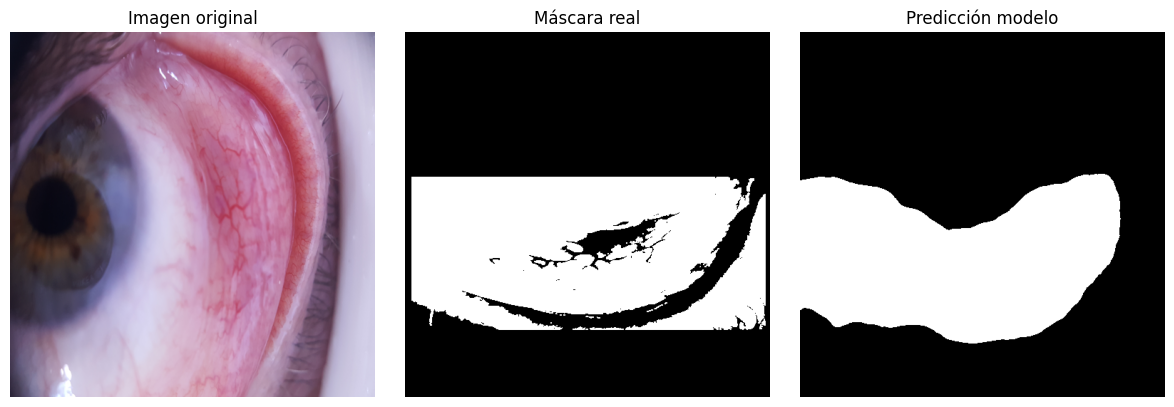

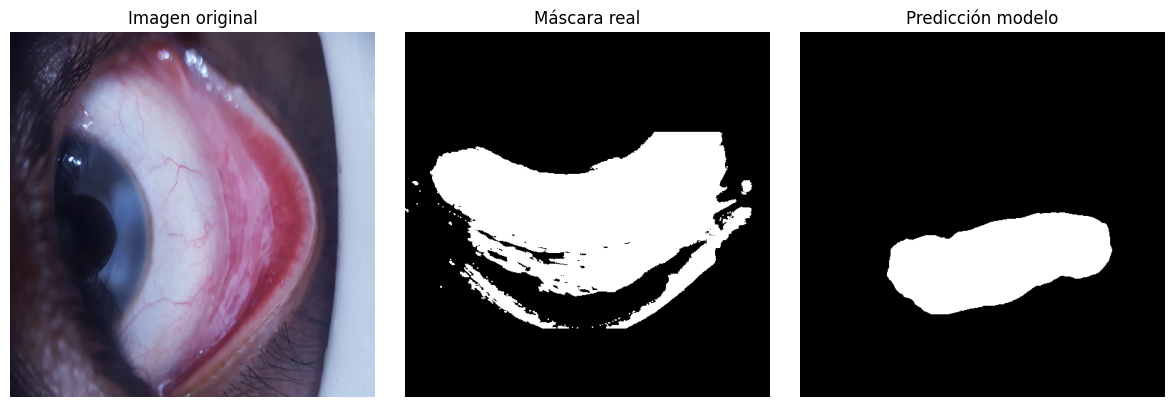

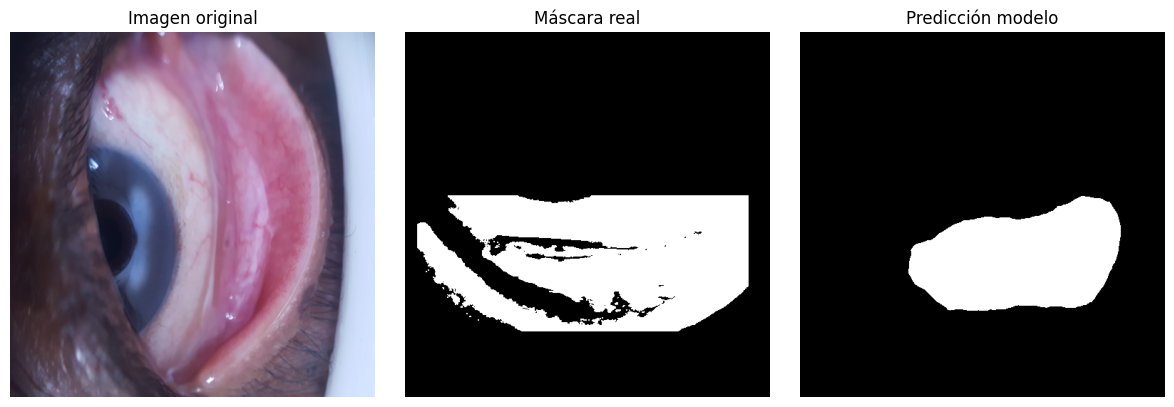

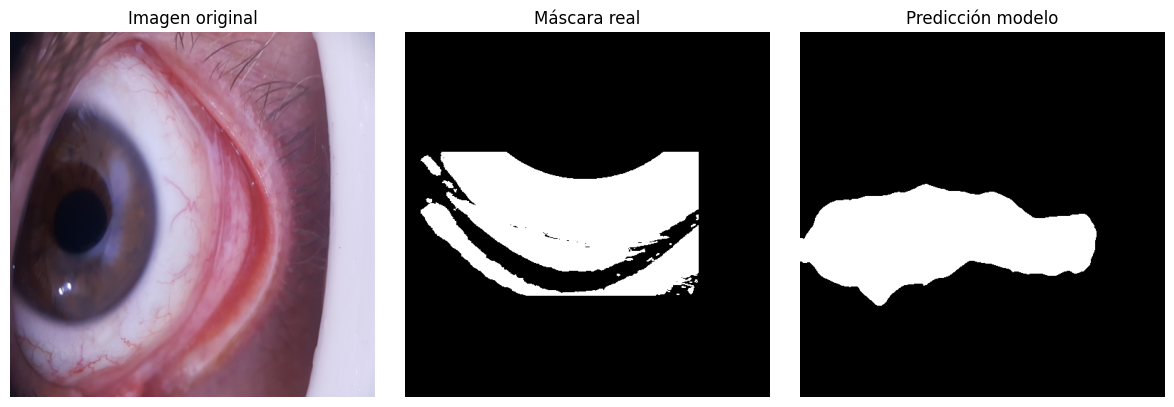

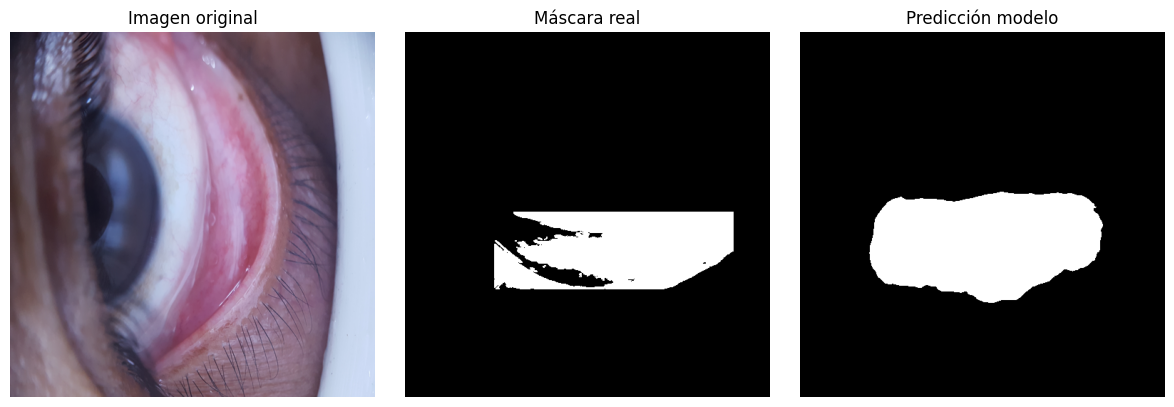

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# Seleccionar 5 muestras aleatorias del test set
samples = split_dataset["test"].shuffle(seed=42).select(range(5))

for i, sample in enumerate(samples):
    # Cargar imagen original (en formato PIL)
    image = Image.open(sample["image_path"]).convert("RGB").resize((512, 512))

    # Preparar entrada para el modelo
    inputs = processor(images=image, return_tensors="pt").to(model.device)

    # Obtener logits (sin necesidad de gradientes)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # (1, num_classes, h, w)

    # Reescalar logits a 512x512
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=(512, 512),
        mode="bilinear",
        align_corners=False
    )

    # Obtener máscara predicha
    predicted_mask = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

    # Cargar máscara real (ya binarizada)
    real_mask = np.array(Image.open(sample["mask_path"]).convert("L").resize((512, 512)))
    real_mask = (real_mask > 0).astype(np.uint8)

    # Mostrar en figura
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image)
    axs[0].set_title("Imagen original")
    axs[1].imshow(real_mask, cmap="gray")
    axs[1].set_title("Máscara real")
    axs[2].imshow(predicted_mask, cmap="gray")
    axs[2].set_title("Predicción modelo")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


## 13. Guardado del modelo base entrenado

En esta celda, guardamos el modelo entrenado utilizando únicamente el dataset original (con imágenes y máscaras provenientes de pacientes de India e Italia). Este modelo aún **no** ha sido ajustado con nuestras propias imágenes adicionales.

Guardamos los archivos necesarios en la carpeta `model_palpebral_segmentation` dentro de Google Drive:

- `pytorch_model.bin`: contiene los pesos del modelo entrenado.
- `config.json`: contiene los metadatos del modelo, incluyendo el número de clases, arquitectura, etc.
- `preprocessor_config.json`: almacena las configuraciones de preprocesamiento necesarias para procesar nuevas imágenes de manera consistente.

Este paso fue crucial para poder usar el modelo más adelante en tareas de inferencia (por ejemplo, al iterar con imágenes propias y de familiares).

Posteriormente, observamos que los resultados no eran completamente satisfactorios, lo que nos llevó a realizar un ajuste del modelo (fine-tuning) con un conjunto de 15 imágenes adicionales — proceso que abordaremos más adelante en el notebook.


In [ ]:
# Ruta destino en Google Drive
save_path = "/content/drive/MyDrive/model_palpebral_segmentation"

# Crear carpeta si no existe (opcional pero seguro)
import os
os.makedirs(save_path, exist_ok=True)

# Guardar modelo en formato clásico (.bin)
model.save_pretrained(save_path, safe_serialization=False)

# Guardar processor (transformaciones de entrada)
processor.save_pretrained(save_path)

print(f"Modelo guardado correctamente en: {save_path}")



Modelo guardado correctamente en: /content/drive/MyDrive/model_palpebral_segmentation


### Verificación del tipo de modelo cargado

En este punto confirmamos que el modelo cargado corresponde efectivamente a la clase `SegformerForSemanticSegmentation`, que es la clase adecuada del modelo SegFormer de HuggingFace.

Esto nos permite asegurarnos de que el objeto `model` fue correctamente inicializado y está listo para realizar inferencias o continuar con entrenamiento. Es una buena práctica realizar este tipo de comprobaciones antes de continuar con procesos más complejos.


In [ ]:
print(type(model))


<class 'transformers.models.segformer.modeling_segformer.SegformerForSemanticSegmentation'>


## 14. Evaluación del modelo con imágenes personales previas al fine-tuning

Luego de haber entrenado el modelo con el dataset original (India/Italia), buscamos evaluar qué tan bien generalizaba a imágenes nuevas y reales. Para ello, se realizaron pruebas con imágenes externas que no pertenecían al conjunto de entrenamiento original.

Inicialmente se utilizó una fotografía personal (`Imagen_Prueba.jpg`) que fue cargada y procesada. Sin embargo, el modelo generó una máscara completamente negra, lo que indicaba que no había identificado ninguna región de la conjuntiva palpebral. Esto evidenció que el modelo no estaba generalizando adecuadamente a nuevas condiciones de iluminación, tonos de piel, dispositivos de captura, etc.

Ante este resultado, se decidió recopilar una nueva serie de **15 imágenes de ojos** de amigos, familiares y de los propios autores, bajo ciertas recomendaciones para emular la calidad del dataset original:
- Imagen cuadrada, bien enfocada y cercana al ojo.
- Cabeza ligeramente inclinada hacia arriba.
- Párpado inferior sostenido hacia abajo para exponer la conjuntiva.
- Iluminación clara, sin flash directo preferentemente.

Cada una de estas imágenes fue iterada manualmente (no mediante bucle `for`) cargándolas desde Google Drive y modificando el nombre de archivo en la celda correspondiente.

> **Observación:** en varios casos, las predicciones generadas seguían siendo incorrectas o poco definidas, lo que reforzó la necesidad de adaptar el modelo a estas nuevas condiciones mediante un ajuste fino (fine-tuning), utilizando estas mismas imágenes con sus respectivas máscaras anotadas manualmente.



Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

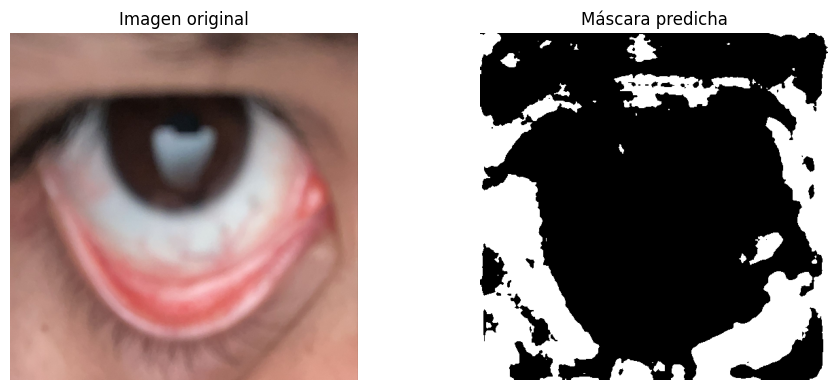

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# Cargar el procesador y el modelo preentrenado
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# 1. Cargar imagen personalizada
img = Image.open("/content/drive/MyDrive/model_palpebral_segmentation/Imagenes/eye_15.jpg").convert("RGB").resize((512, 512))

# 2. Preprocesar con el processor entrenado
inputs = processor(images=img, return_tensors="pt").to(model.device)

# 3. Pasar por el modelo
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # (1, num_classes, h, w)

# 4. Escalar salida al tamaño deseado
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=(512, 512),
    mode="bilinear",
    align_corners=False
)

# 5. Obtener predicción (clase más probable por píxel)
predicted_mask = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# 6. Visualizar
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Máscara predicha")
plt.axis("off")

plt.tight_layout()
plt.show()


## 15. Instalación de `pycocotools`

Antes de procesar las anotaciones de las nuevas imágenes, fue necesario instalar la biblioteca `pycocotools`, la cual permite leer archivos en formato COCO (Common Objects in Context), un estándar ampliamente utilizado para tareas de segmentación y detección de objetos.

Esto se debió a que las 15 nuevas imágenes fueron anotadas manualmente usando la plataforma [MakeSense.ai](https://www.makesense.ai/), y las anotaciones se exportaron en formato `COCO JSON`. Esta biblioteca facilita extraer las máscaras a partir de dicha estructura de anotaciones.

```python
!pip install pycocotools


In [ ]:
!pip install pycocotools


## 16. Conversión de anotaciones COCO a máscaras binarias PNG

En esta celda realizamos la conversión de las anotaciones exportadas desde MakeSense en formato `COCO JSON` hacia imágenes de máscaras binarias reales en formato `.png`.

Este proceso fue esencial para transformar las segmentaciones poligonales hechas manualmente sobre las 15 nuevas imágenes en máscaras que pudieran ser utilizadas por el modelo de segmentación. Aquí los pasos clave:

1. **Se cargó el archivo `palpebral_masks_annotations.json`** generado por MakeSense.
2. **Se extrajo la información de cada anotación** (vínculo con la imagen, altura, anchura y los polígonos).
3. **Se decodificaron las anotaciones** utilizando `pycocotools`, ya sea como listas de polígonos o en formato RLE.
4. **Se generó la máscara binaria correspondiente** (área segmentada en blanco `255`, el resto en negro `0`).
5. **Se guardó cada máscara en una nueva carpeta (`masks_from_coco`)** con el mismo nombre que su imagen correspondiente.

> Resultado: 15 archivos `.png` listos para usarse como máscaras en el entrenamiento, alineados perfectamente con sus imágenes correspondientes (`eye_01.png` a `eye_15.png`).





In [ ]:
import json
import os
import numpy as np
from PIL import Image
from pycocotools import mask as maskUtils

# Ruta a archivo COCO exportado de Makesense
coco_json_path = "/content/drive/MyDrive/model_palpebral_segmentation/palpebral_masks_annotations.json"

# Carpeta donde se guardarán las máscaras
output_mask_dir = "/content/drive/MyDrive/model_palpebral_segmentation/masks_from_coco"
os.makedirs(output_mask_dir, exist_ok=True)

# Cargar el JSON
with open(coco_json_path) as f:
    coco_data = json.load(f)

images_info = {img["id"]: img for img in coco_data["images"]}

# Crear máscara para cada imagen
for ann in coco_data["annotations"]:
    image_id = ann["image_id"]
    image_info = images_info[image_id]
    file_name = os.path.splitext(image_info["file_name"])[0]  # 'eye_01' sin extensión

    height = image_info["height"]
    width = image_info["width"]

    # Decodificar la segmentación (COCO RLE o polígono)
    segm = ann["segmentation"]
    if isinstance(segm, list):  # polígono
        rle = maskUtils.frPyObjects(segm, height, width)
        m = maskUtils.decode(rle)
        mask = np.sum(m, axis=2).astype(np.uint8) * 255  # convertir a 0/255
    else:  # RLE
        m = maskUtils.decode(segm)
        mask = m.astype(np.uint8) * 255

    # Guardar la máscara como PNG
    mask_img = Image.fromarray(mask)
    mask_img.save(os.path.join(output_mask_dir, f"{file_name}.png"))

print(" Conversión completada. Máscaras guardadas en:", output_mask_dir)


✅ Conversión completada. Máscaras guardadas en: /content/drive/MyDrive/model_palpebral_segmentation/masks_from_coco


## 17. Preparación del nuevo conjunto de datos con imágenes personalizadas

Luego de convertir las anotaciones COCO a máscaras en formato `.png`, **no fue necesario aplicar binarización adicional**, ya que las máscaras generadas manualmente con MakeSense eran inherentemente binarias (con valores 0 para fondo y 255 para la región de interés).  
  
Posteriormente, **se acomodaron manualmente** tanto las imágenes (`eye_01.jpg` a `eye_15.jpg`) como sus respectivas máscaras (`eye_01.png` a `eye_15.png`) dentro del dataset general. Específicamente:

- Las imágenes fueron colocadas en la carpeta: `/content/drive/MyDrive/segmentation_dataset/images`
- Las máscaras se colocaron en: `/content/drive/MyDrive/segmentation_dataset/binarized_masks`

---

### Reutilización del modelo previamente entrenado y preparación del dataset extendido

En esta celda cargamos el modelo que ya habíamos entrenado con la base de datos original (India + Italia), y ahora **utilizamos ese mismo modelo como punto de partida** para incorporar las nuevas imágenes y realizar un entrenamiento adicional (fine-tuning).

Pasos clave del código:

1. **Carga del modelo y el procesador previamente guardado** desde la carpeta `model_palpebral_segmentation`.
2. **Lectura y emparejamiento de imágenes y máscaras** en un DataFrame de Pandas.
3. **Redimensionamiento y procesamiento de los datos**:
   - Las imágenes y máscaras se redimensionan a `512 × 512`.
   - Las máscaras se convierten a formato binario (0 y 1), aunque esto es solo por seguridad.
   - Se codifican usando el `processor` para obtener tensores compatibles con el modelo.
4. **Conversión a formato HuggingFace Dataset**, necesario para su entrenamiento con Transformers.
5. **Separación del conjunto en entrenamiento y prueba (train/test)** utilizando una proporción del 85% para entrenamiento y 15% para prueba.

Esta es una parte clave del flujo, ya que aquí es donde **unificamos el conocimiento previo del modelo con las nuevas muestras reales**, lo que permite adaptar el modelo a datos más representativos de nuestro contexto (población mexicana).


In [ ]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from datasets import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import os
import torch

from google.colab import drive
drive.mount('/content/drive')

# Ruta al Drive
image_dir = "/content/drive/MyDrive/segmentation_dataset/images"
mask_dir  = "/content/drive/MyDrive/segmentation_dataset/binarized_masks"
model_dir = "/content/drive/MyDrive/model_palpebral_segmentation"

# Cargar modelo pre-entrenado previamente
processor = SegformerImageProcessor.from_pretrained(model_dir)
model     = SegformerForSemanticSegmentation.from_pretrained(model_dir)

# Leer archivos existentes
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")])
mask_files  = sorted([f for f in os.listdir(mask_dir) if f.endswith(".jpg") or f.endswith(".png")])

# Crear dataframe
df = pd.DataFrame({
    "image_path": [os.path.join(image_dir, f) for f in image_files],
    "mask_path":  [os.path.join(mask_dir, f)  for f in mask_files]
})

# Preprocesamiento
target_size = (512, 512)

def preprocess(example):
    image = Image.open(example["image_path"]).convert("RGB").resize(target_size)
    mask  = Image.open(example["mask_path"]).convert("L").resize(target_size)

    # Binarizar la máscara
    mask_np = np.array(mask)
    binary_mask = (mask_np > 0).astype(np.uint8)

    encoded = processor(images=image, segmentation_maps=binary_mask, return_tensors="pt")
    return {
        "pixel_values": encoded["pixel_values"].squeeze(),  # (3, 512, 512)
        "labels": encoded["labels"].squeeze()               # (512, 512)
    }

# Aplicar procesamiento
dataset = Dataset.from_pandas(df).map(preprocess)

# Dividir en train/test
split_dataset = dataset.train_test_split(test_size=0.15, seed=42)


Mounted at /content/drive


Map:   0%|          | 0/148 [00:00<?, ? examples/s]

### 17.1 Data Augmentation: Geometric Transformations for Generalization

Para mejorar la capacidad de generalización del modelo y reducir la dependencia del dataset base, se incorporaron transformaciones geométricas y de color utilizando la librería `torchvision.transforms.v2`.  
Estas transformaciones permiten que el modelo sea más robusto ante diferentes condiciones de captura, simulando variaciones reales en ángulo, iluminación y posición del ojo.

**Transformaciones aplicadas:**
- `RandomResizedCrop(size=(512,512), scale=(0.9,1.1))` → simula acercamientos y recortes leves.  
- `RandomHorizontalFlip(p=0.5)` → refleja horizontalmente para cubrir ambos ojos.  
- `RandomRotation(degrees=10)` → introduce rotaciones pequeñas (±10°).  
- `ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1)` → ajusta brillo y saturación.

Estas operaciones se aplican **únicamente sobre el conjunto de entrenamiento**, manteniendo las imágenes de prueba sin modificaciones para evaluar objetivamente el rendimiento del modelo.


In [ ]:
from torchvision.transforms import v2

# Transformaciones geométricas y de color para aumentar la generalización
train_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(512, 512), scale=(0.9, 1.1), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
])


In [ ]:
# Preprocesamiento
target_size = (512, 512)

def preprocess(example):
    image = Image.open(example["image_path"]).convert("RGB").resize(target_size)
    mask  = Image.open(example["mask_path"]).convert("L").resize(target_size)

    # Binarizar la máscara
    mask_np = np.array(mask)
    binary_mask = (mask_np > 0).astype(np.uint8)

    # Aplicar transformaciones geométricas sólo si el ejemplo lo permite
    if example.get("augment", False):
        image = train_transforms(image)
        # Importante: rotar y espejar también la máscara de la misma forma
        mask_pil = Image.fromarray(binary_mask)
        mask_pil = train_transforms(mask_pil)
        binary_mask = np.array(mask_pil)

    encoded = processor(images=image, segmentation_maps=binary_mask, return_tensors="pt")
    return {
        "pixel_values": encoded["pixel_values"].squeeze(),  # (3, 512, 512)
        "labels": encoded["labels"].squeeze()               # (512, 512)
    }

# Aplicar procesamiento
dataset = Dataset.from_pandas(df).map(preprocess)

# Dividir en train/test
split_dataset = dataset.train_test_split(test_size=0.15, seed=42)

# Añadir etiqueta 'augment' solo al conjunto de entrenamiento
train_dataset = split_dataset["train"].add_column("augment", [True] * len(split_dataset["train"]))
test_dataset  = split_dataset["test"].add_column("augment", [False] * len(split_dataset["test"]))

# Aplicar el preprocesamiento
train_dataset = train_dataset.map(preprocess)
test_dataset  = test_dataset.map(preprocess)



Map:   0%|          | 0/148 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/125 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/23 [00:00<?, ? examples/s]

Map:   0%|          | 0/125 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

## 18. Entrenamiento adicional del modelo (Fine-Tuning) con datos propios

En este bloque realizamos el proceso de *fine-tuning* utilizando las imágenes que recolectamos manualmente (15 fotografías nuevas), previamente anotadas en MakeSense y organizadas en nuestro dataset final. Este paso consiste en continuar el entrenamiento del modelo ya entrenado con el dataset original (India e Italia), pero ahora incorporando también nuestras imágenes reales para mejorar su desempeño sobre nuestra población objetivo (pacientes mexicanos).

Primero definimos la función `compute_metrics`, donde calculamos las métricas de desempeño: **IoU (Intersection over Union)** y **Dice Coefficient**, dos indicadores ampliamente utilizados para evaluar la calidad de segmentación semántica. Para ello:

- Reescalamos los `logits` de salida del modelo a tamaño 512x512 para que coincidan con la dimensión de las máscaras reales.
- Aplicamos `argmax` sobre los `logits` para obtener la clase predicha por píxel.
- Calculamos IoU y Dice para cada par de imagen–máscara.
- Promediamos todos los valores del batch.

Luego, definimos los argumentos de entrenamiento con `TrainingArguments` de Hugging Face:

- Entrenamos por 5 épocas adicionales.
- Usamos un `batch_size` de 2 imágenes.
- Evaluamos y guardamos el modelo al final de cada época.
- Activamos `fp16` si hay GPU compatible, lo que acelera y optimiza el entrenamiento.
- Indicamos que se seleccione automáticamente el mejor modelo con base en la métrica `"mean_dice"`.

Finalmente, iniciamos el entrenamiento usando la clase `Trainer` de Hugging Face, que gestiona el bucle de entrenamiento, validación y almacenamiento del mejor modelo automáticamente.

Este fine-tuning es clave para adaptar el modelo a condiciones reales y específicas de nuestro contexto.

In [ ]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn.functional as F
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred  # logits: (batch, num_classes, h, w)
    logits = torch.tensor(logits)

    # Reescalar logits al tamaño de labels (512x512)
    upsampled_logits = F.interpolate(
        logits,
        size=(512, 512),
        mode="bilinear",
        align_corners=False
    )

    preds = torch.argmax(upsampled_logits, dim=1).cpu().numpy()

    # Asegurar que labels sea numpy
    labels = np.array(labels)

    ious, dices = [], []
    for pred, label in zip(preds, labels):
        inter = np.logical_and(pred == 1, label == 1).sum()
        union = np.logical_or(pred == 1, label == 1).sum()
        iou = (inter + 1e-6) / (union + 1e-6)
        dice = (2 * inter + 1e-6) / (pred.sum() + label.sum() + 1e-6)
        ious.append(iou)
        dices.append(dice)

    return {
        "mean_iou": np.mean(ious),
        "mean_dice": np.mean(dices)
    }

training_args = TrainingArguments(
    output_dir="./segformer_finetuned_output",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=5,  # 5 épocas más
    learning_rate=5e-5,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mean_dice",
    greater_is_better=True,
    remove_unused_columns=False,
    fp16=torch.cuda.is_available()
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jose-gonzalez0672 (jose-gonzalez0672-universidad-de-guadalajara) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=315, training_loss=0.24151952531602647, metrics={'train_runtime': 586.3912, 'train_samples_per_second': 1.066, 'train_steps_per_second': 0.537, 'total_flos': 1.095497220096e+16, 'train_loss': 0.24151952531602647, 'epoch': 5.0})

### Resultados del entrenamiento (Fine-Tuning)

Una vez finalizado el entrenamiento con nuestras imágenes personalizadas, el modelo arrojó los siguientes resultados por época. Se observan métricas clave como:

- **Training Loss y Validation Loss:** La pérdida durante entrenamiento y validación tiende a disminuir en general, lo cual indica que el modelo está aprendiendo progresivamente.
- **Mean IoU (Intersection over Union):** Fluctúa entre 0.26 y 0.36 aproximadamente, lo cual representa una segmentación aceptable considerando el tamaño reducido del dataset y la complejidad del área a segmentar.
- **Mean Dice Coefficient:** Alcanzó un valor máximo de aproximadamente **0.50**, lo cual indica una buena superposición entre la predicción y la máscara real, sobre todo comparado con el rendimiento previo del modelo base (sin fine-tuning).

Aunque algunas métricas fluctúan ligeramente entre épocas, se observa una mejora general respecto al entrenamiento original, reflejando que el fine-tuning con nuestras 15 imágenes personalizadas permitió al modelo ajustarse mejor a las condiciones reales de nuestras capturas.

**El propósito de emplear las transformaciones geométricas fue aumentar la robustez del modelo frente a cambios en la iluminación, el ángulo de captura o la posición de la conjuntiva palpebral.**

El resultado esperado fue una **mejor continuidad espacial** en la segmentación y una menor sensibilidad a pequeñas variaciones visuales.

El modelo con mejor rendimiento fue seleccionado automáticamente con base en el valor más alto de **Mean Dice**.



## 19. Visualización de las predicciones del modelo con las nuevas imágenes utilizadas para el fine-tuning

En esta sección iteramos sobre las 15 nuevas imágenes que fueron recabadas de distintos voluntarios (familiares, amigos y propias). Estas imágenes fueron las que se utilizaron en el proceso de fine-tuning, y ahora se visualizan sus resultados para verificar si el modelo logró aprender a segmentar de manera precisa la conjuntiva palpebral en condiciones más reales y personalizadas.

Se muestran tres elementos por cada ejemplo:
- La **imagen original** del ojo,
- La **máscara real** (generada en Makesense),
- Y la **máscara predicha** por el modelo.

Al observar los resultados, es notorio que en la mayoría de los casos el modelo logra detectar de manera razonable la región de interés. Sin embargo, es importante tener en cuenta que estas imágenes formaron parte del conjunto de entrenamiento, por lo que era esperable que las predicciones fueran buenas. Por esa razón, **consideramos la posibilidad de un overfitting**, ya que el modelo podría estar “memorizando” estas muestras en lugar de generalizar.

Este análisis visual sirvió como punto de partida para una siguiente prueba con una imagen completamente nueva (no vista durante el entrenamiento), lo cual se explora más adelante.


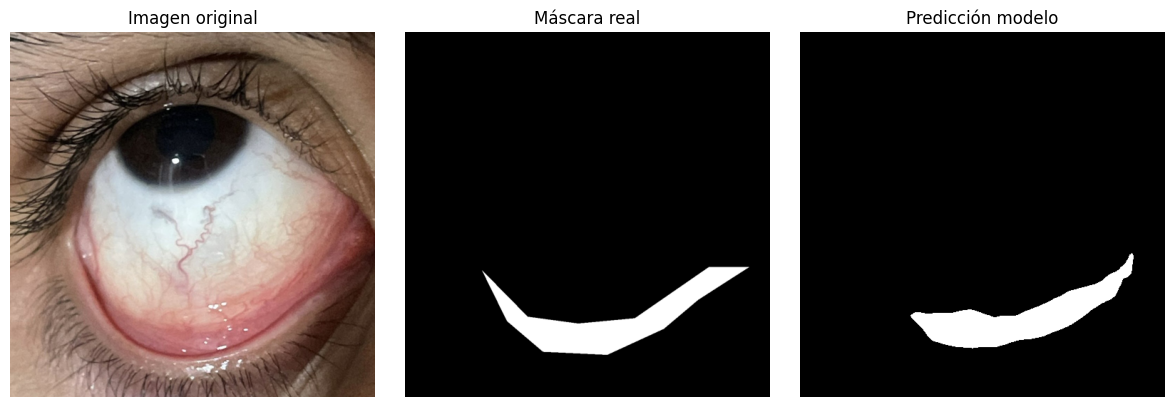

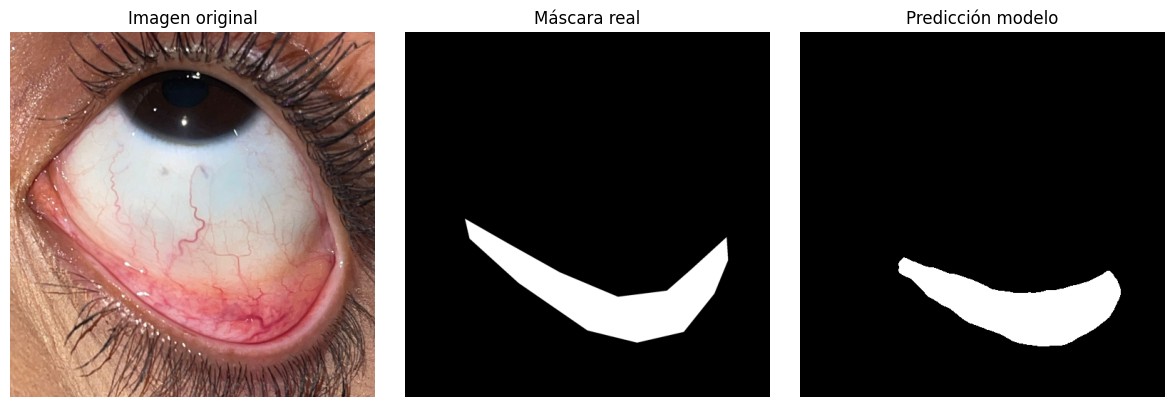

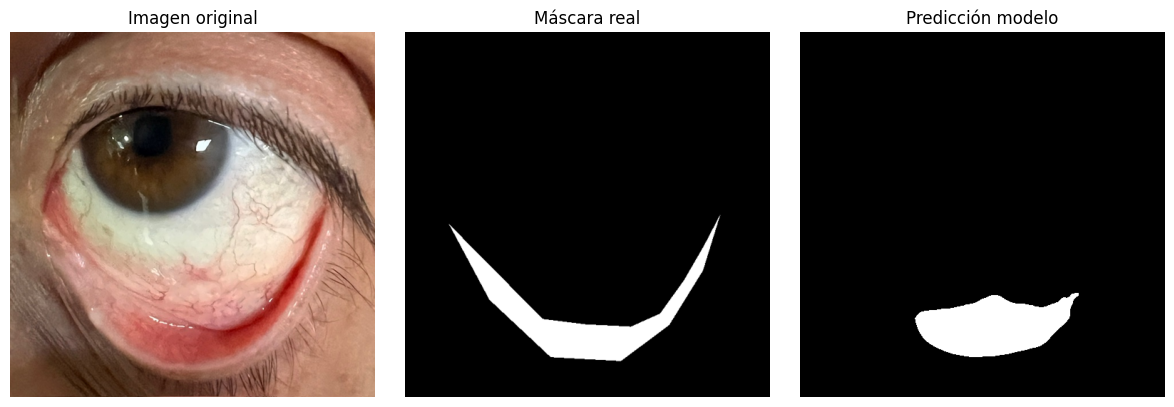

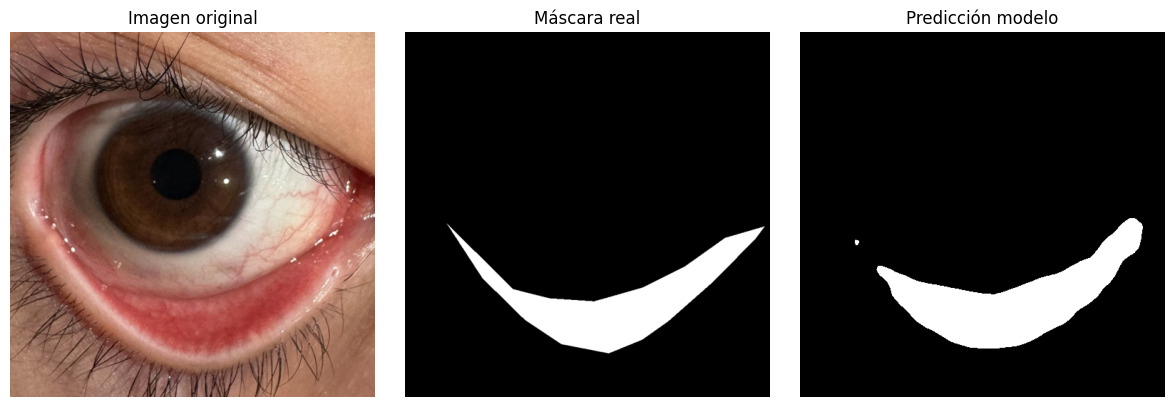

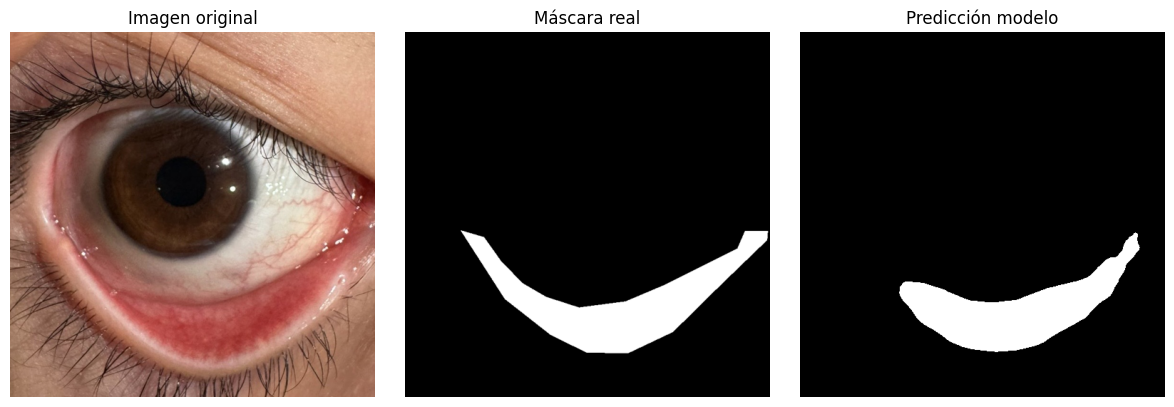

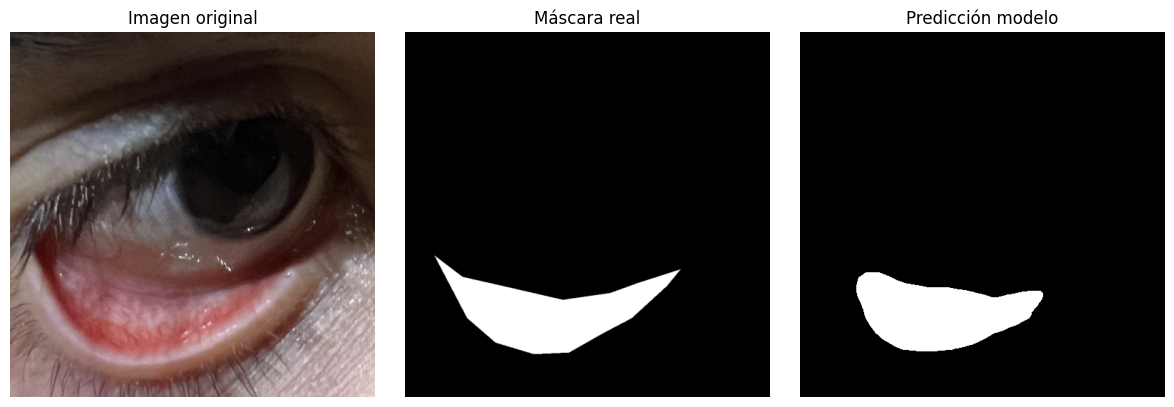

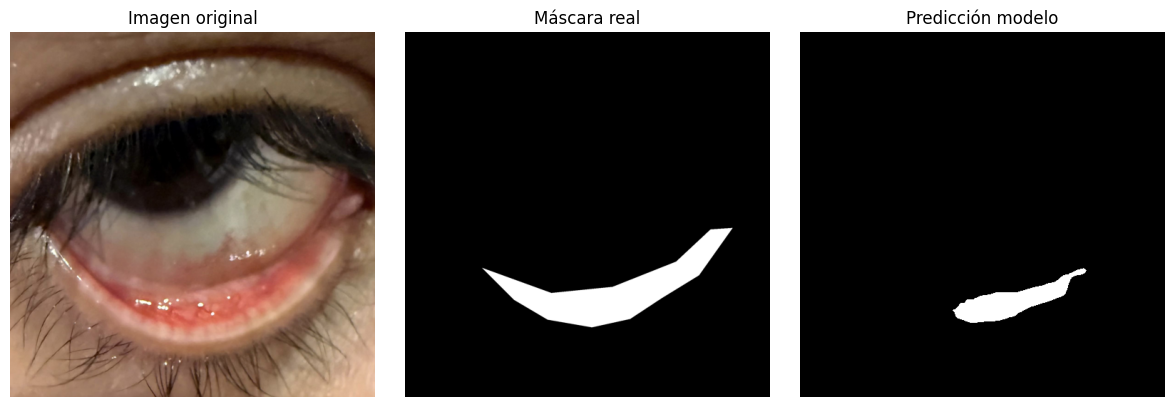

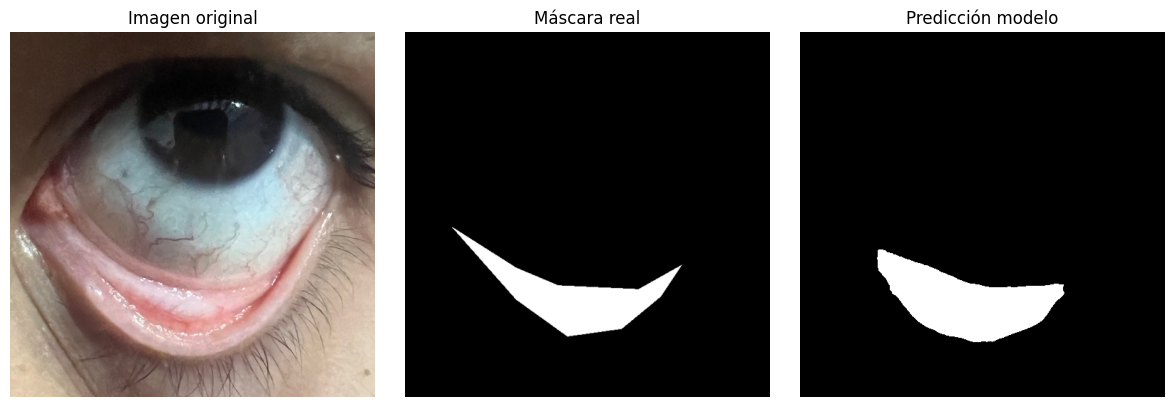

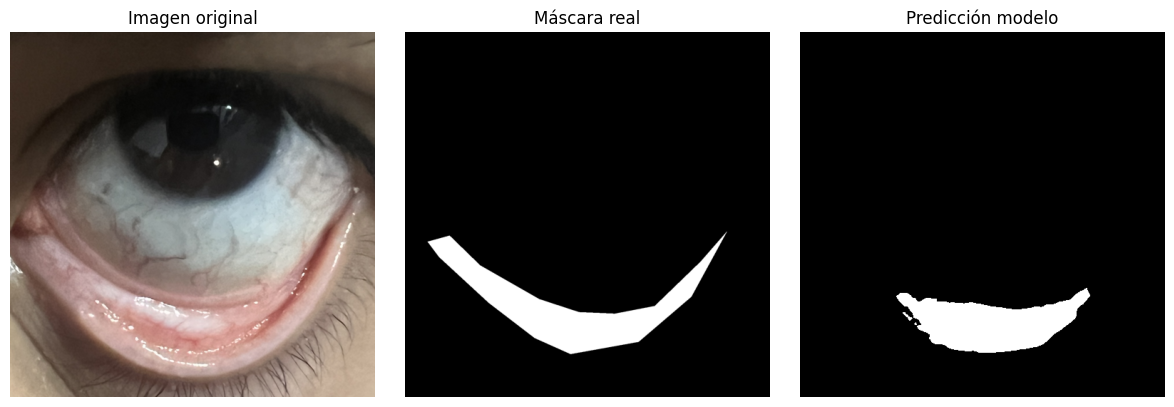

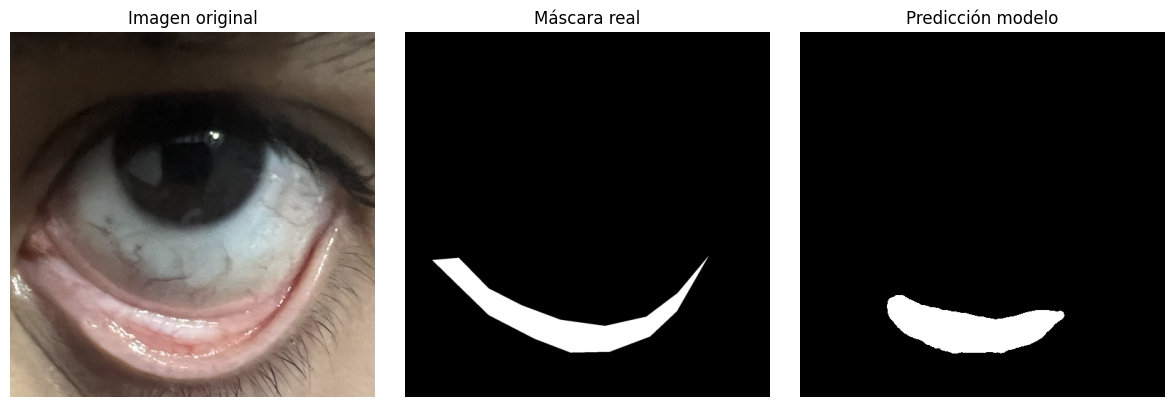

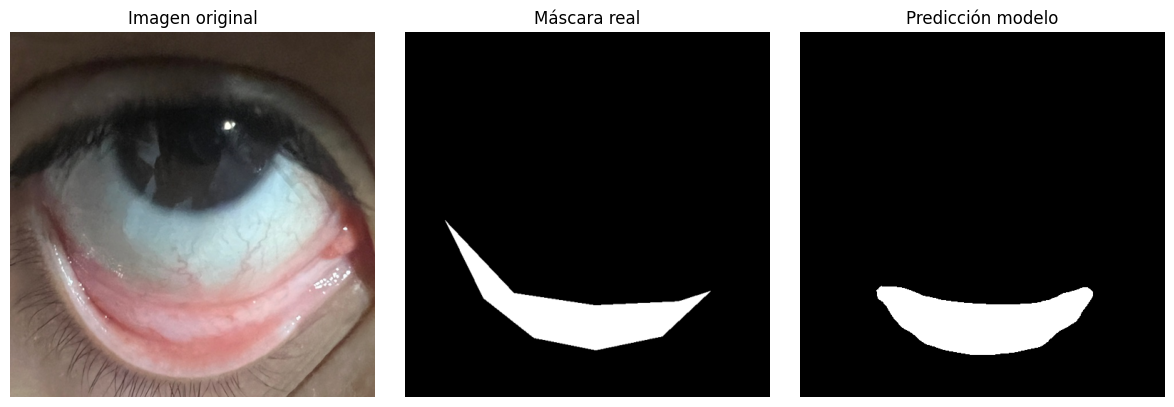

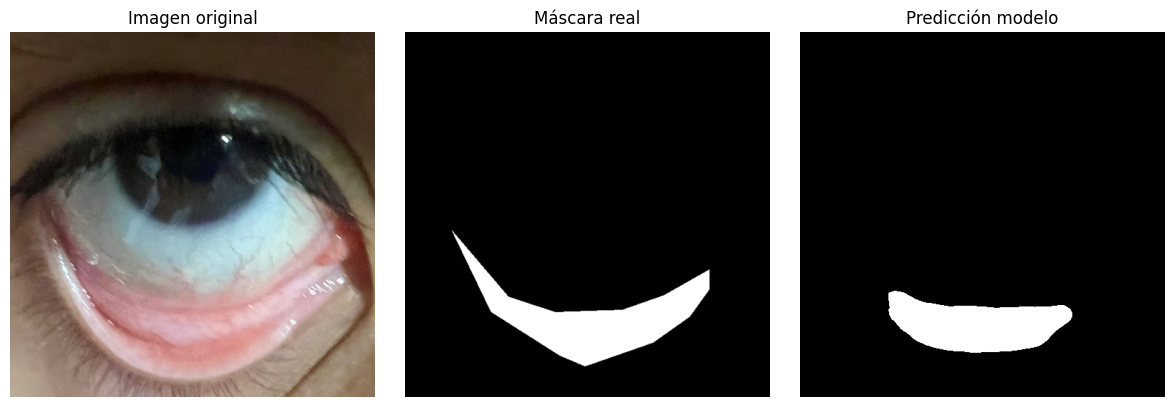

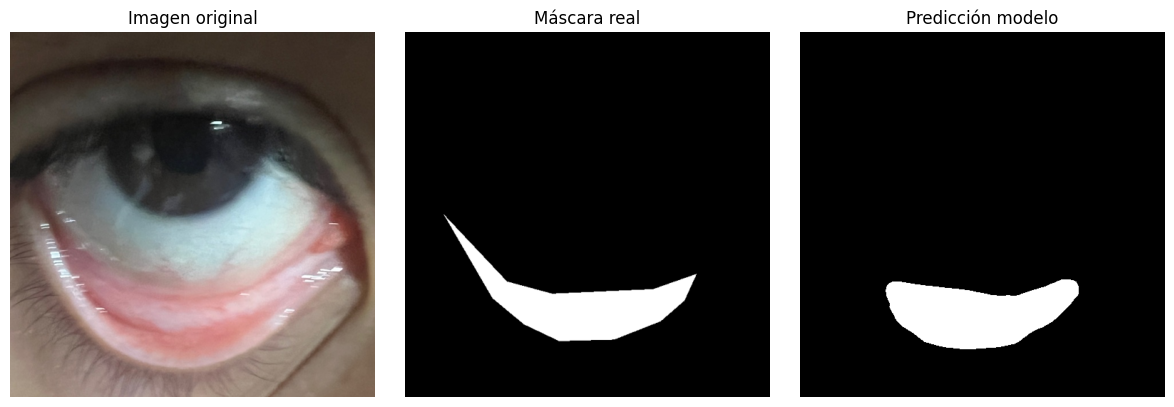

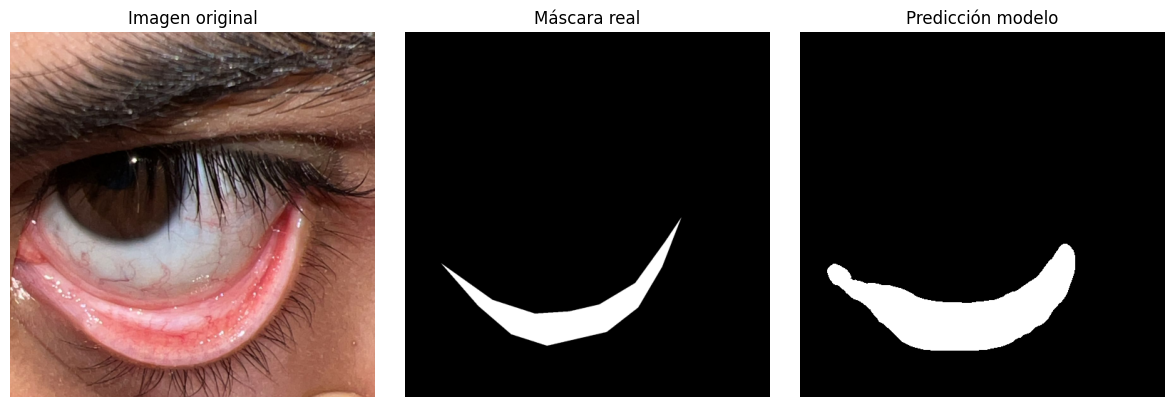

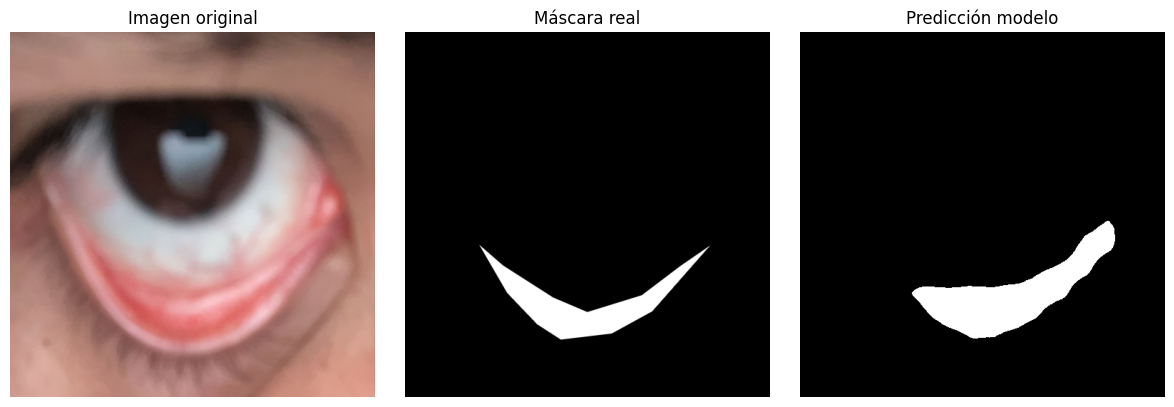

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

# Rutas
img_dir = "/content/drive/MyDrive/model_palpebral_segmentation/Imagenes"
mask_dir = "/content/drive/MyDrive/model_palpebral_segmentation/masks_from_coco"

image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")])

for img_name in image_files:
    image_path = os.path.join(img_dir, img_name)
    mask_path = os.path.join(mask_dir, img_name.replace(".jpg", ".png"))

    image = Image.open(image_path).convert("RGB").resize((512, 512))
    mask = Image.open(mask_path).convert("L").resize((512, 512))

    encoded = processor(images=image, return_tensors="pt")

    # Forzar a usar half precision (fp16) si tu modelo fue entrenado así
    encoded["pixel_values"] = encoded["pixel_values"].half().to(model.device)

    with torch.no_grad():
        outputs = model(**encoded)
        logits = outputs.logits

        pred_mask = torch.nn.functional.interpolate(
            logits, size=(512, 512), mode="bilinear", align_corners=False
        )
        pred = pred_mask.argmax(dim=1)[0].cpu().numpy()

    # Mostrar los resultados
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(image); axes[0].set_title("Imagen original")
    axes[1].imshow(mask, cmap="gray"); axes[1].set_title("Máscara real")
    axes[2].imshow(pred, cmap="gray"); axes[2].set_title("Predicción modelo")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

## 20. Guardado del modelo ajustado (fine-tuned)

Una vez finalizado el entrenamiento con el nuevo conjunto de datos (que incluye imágenes originales del dataset y las 15 imágenes personalizadas añadidas), procedemos a **guardar el modelo fine-tuned** en una nueva ruta dentro de Google Drive.

Este modelo representa una versión más especializada y adaptada a imágenes de ojos reales (propias y de voluntarios), y su almacenamiento permitirá futuras inferencias sin necesidad de reentrenar desde cero.

Tanto el modelo como el `processor` (encargado del preprocesamiento de imágenes) son guardados mediante el método `save_pretrained`, en el directorio: /content/drive/MyDrive/model_palpebral_finetuned

De esta forma, se conserva el estado final del modelo ajustado para futuras pruebas, despliegues o mejoras.




In [ ]:

# Nueva ruta para guardar el modelo fine-tuned
save_path = "/content/drive/MyDrive/model_palpebral_segmentation_augmented"

# Crear carpeta si no existe
import os
os.makedirs(save_path, exist_ok=True)

# Guardar modelo
model.save_pretrained(save_path)
processor.save_pretrained(save_path)

print(f"Modelo guardado en: {save_path}")



Modelo guardado en: /content/drive/MyDrive/model_palpebral_segmentation_augmented


## 21. Validación externa del modelo ajustado con una imagen inédita

En esta etapa final, **ponemos a prueba la capacidad de generalización del modelo fine-tuned**, utilizando una **imagen completamente nueva**, perteneciente a un usuario distinto a los incluidos durante el entrenamiento.

El objetivo es detectar un posible **overfitting**: si el modelo sólo aprendió a segmentar correctamente las 15 imágenes añadidas y no logra hacerlo con datos no vistos, entonces no sería útil en la práctica.

Aquí se realiza lo siguiente:

1. **Se carga el modelo fine-tuned** directamente desde Google Drive, así como su `processor`.
2. **Se carga y preprocesa la imagen nueva**, redimensionándola a 512x512 píxeles.
3. El modelo realiza la **predicción de la máscara** correspondiente a la conjuntiva palpebral.
4. Finalmente, se muestran dos imágenes:
   - A la izquierda: la imagen original.
   - A la derecha: la **máscara segmentada** generada por el modelo.

El resultado fue **satisfactorio**, ya que el modelo logró segmentar correctamente una imagen totalmente nueva, lo cual **indica que generaliza adecuadamente** y no presentó un overfitting evidente.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


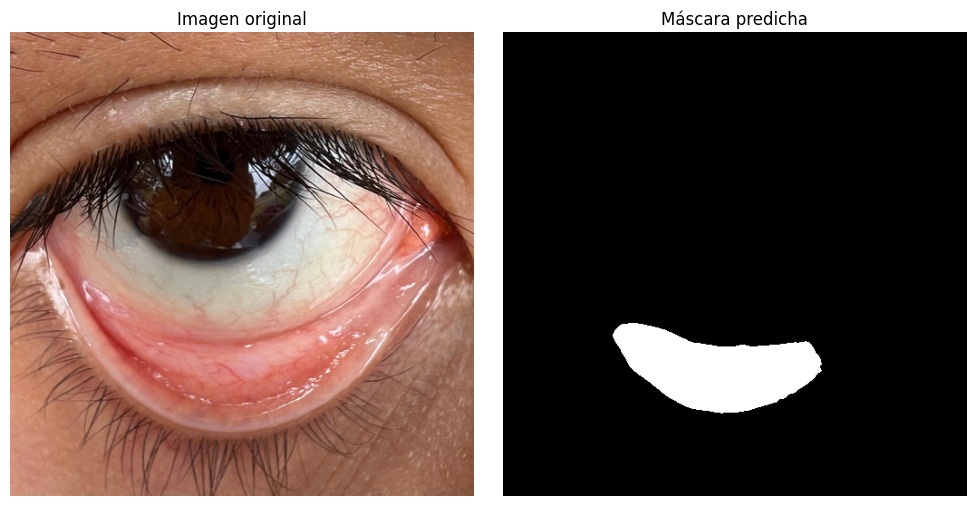

In [ ]:
from pathlib import Path
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Ruta del modelo entrenado en Google Drive
model_dir = Path("/content/drive/MyDrive/model_palpebral_segmentation_augmented")

# Cargar modelo y procesador usando ruta absoluta como string
model = SegformerForSemanticSegmentation.from_pretrained(
    str(model_dir),
    local_files_only=True
).to("cuda" if torch.cuda.is_available() else "cpu")

processor = SegformerImageProcessor.from_pretrained(
    str(model_dir),
    local_files_only=True
)

# Ruta de la imagen nueva
image_path = "/content/drive/MyDrive/Imagen_Prueba.jpg"
image = Image.open(image_path).convert("RGB").resize((512, 512))

# Preprocesamiento
inputs = processor(images=image, return_tensors="pt")
inputs["pixel_values"] = inputs["pixel_values"].to(model.device).to(model.dtype)

# Predicción
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    pred_mask = torch.nn.functional.interpolate(
        logits, size=(512, 512), mode="bilinear", align_corners=False
    )
    pred = pred_mask.argmax(dim=1)[0].cpu().numpy()

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title("Imagen original")
axes[1].imshow(pred, cmap="gray")
axes[1].set_title("Máscara predicha")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()



### **Comparación entre el modelo Fine-Tuned y el modelo Augmented**

Tras aplicar *data augmentation*, se observaron mejoras en la coherencia de las predicciones y en la capacidad de generalización frente a imágenes externas.

| Versión del modelo | Descripción | Desempeño relativo | Observaciones |
|--------------------|-------------|--------------------|----------------|
| Fine-Tuned | Entrenado con dataset original | Base | Buen desempeño, pero sensible a rotaciones y brillo desigual. |
| Augmented | Entrenado con transformaciones geométricas | ↑ Mejor generalización | Más robusto ante variaciones de ángulo e iluminación. |

El modelo resultante se guardó bajo el nombre  
**`model_palpebral_segmentation_augmented`**,  
manteniendo ambas versiones disponibles para análisis y validación.
